In [3]:
!pip install scanpy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=96c64bbb900e9a23bbfdc68bf3d42c1dd65f7a9e3f68e7e8e3f91e0f170be33a
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import pandas as pd
import scanpy as sc
from anndata import AnnData


In [6]:
train = sc.read_h5ad('/content/drive/MyDrive/train_set.h5ad')
test = sc.read_h5ad('/content/drive/MyDrive/test_set.h5ad')

In [7]:
raw = sc.read_h5ad('/content/drive/MyDrive/brain_raw.h5ad')
raw


AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC', 'mt', 'ribo', 'hb'

In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics

sc.pp.filter_cells(raw,min_genes=200)  # 200 genes per cell

# filter genes expressed in too few cells
sc.pp.filter_genes(raw, min_cells=3)

# calculate the percentage of mitochondrial genes
raw.var['mt'] = raw.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(raw, qc_vars=['mt'], inplace=True)

#high mitochondrial content
raw = raw[raw.obs['pct_counts_mt'] < 10, :]

#normalization
sc.pp.normalize_total(raw, target_sum=1e4)  #
sc.pp.log1p(raw)
sc.pp.highly_variable_genes(raw, n_top_genes=2000, subset=True)




/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
X = raw.X
y = raw.obs['cell_ontology_class']

# encode labels and split into train/test sets
y_encoded = pd.factorize(y)[0]
label_mapping = dict(enumerate(pd.factorize(y)[1]))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)



In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],  #
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto'],  # coefficient
}


svc = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [12]:
#predcit
from sklearn.metrics import classification_report, accuracy_score, f1_score
y_pred = best_svm.predict(X_test)

#metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


report = classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y)])
print("Classification Report:\n", report)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Test Accuracy: 0.98
F1 Score: 0.98
Classification Report:
                                 precision    recall  f1-score   support

           Bergmann glial cell       0.97      0.97      0.97       138
                     astrocyte       0.99      0.99      0.99       463
                brain pericyte       1.00      1.00      1.00       224
              endothelial cell       1.00      0.99      0.99        79
                        neuron       0.94      0.96      0.95        52
               oligodendrocyte       0.80      0.86      0.83        14
oligodendrocyte precursor cell       1.00      0.98      0.99        51

                      accuracy                           0.98      1021
                     macro avg       0.96      0.96      0.96      1021
                  weighted avg       0.98      0.98      0.98      1021

Confusion Matrix:
 [[134   1   0   0   0   3   0]
 [  2 458   0   0   3   0   0]
 [  0   1 223   0   0   0   0]
 [  0   0   1  78   0   0   0]
 [ 

In [ ]:
f1

0.9844288748402898

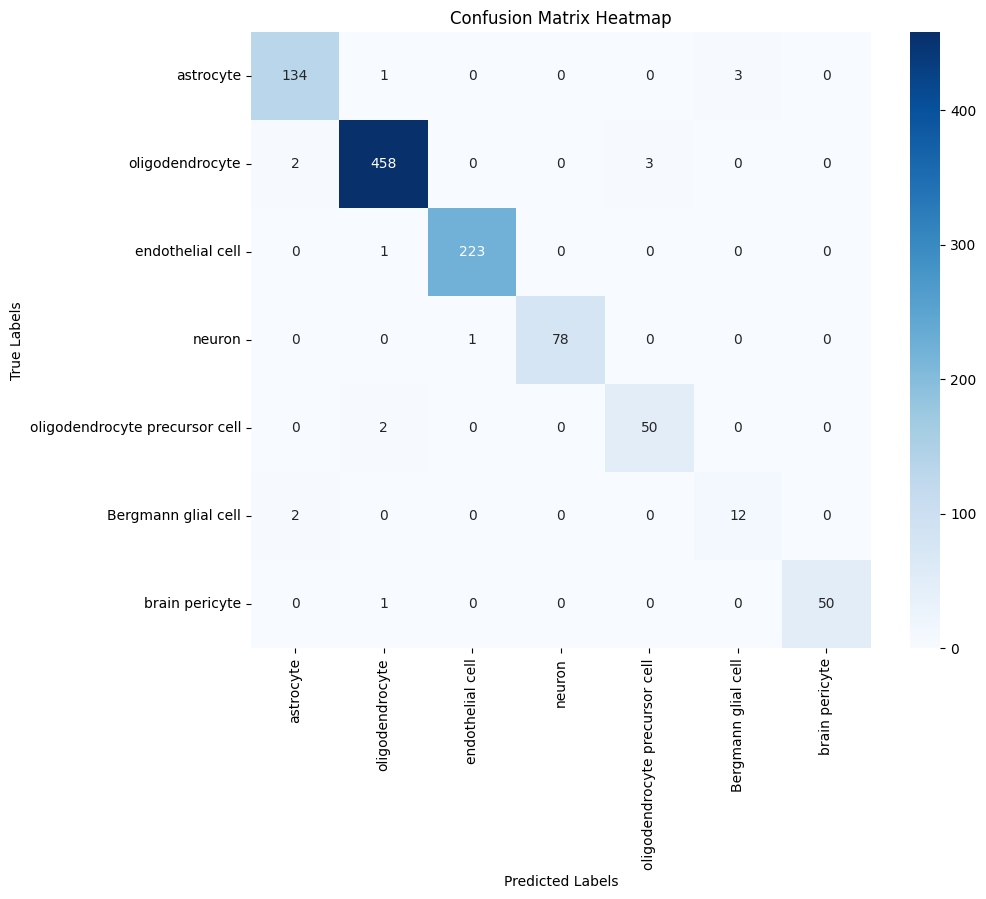

In [ ]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


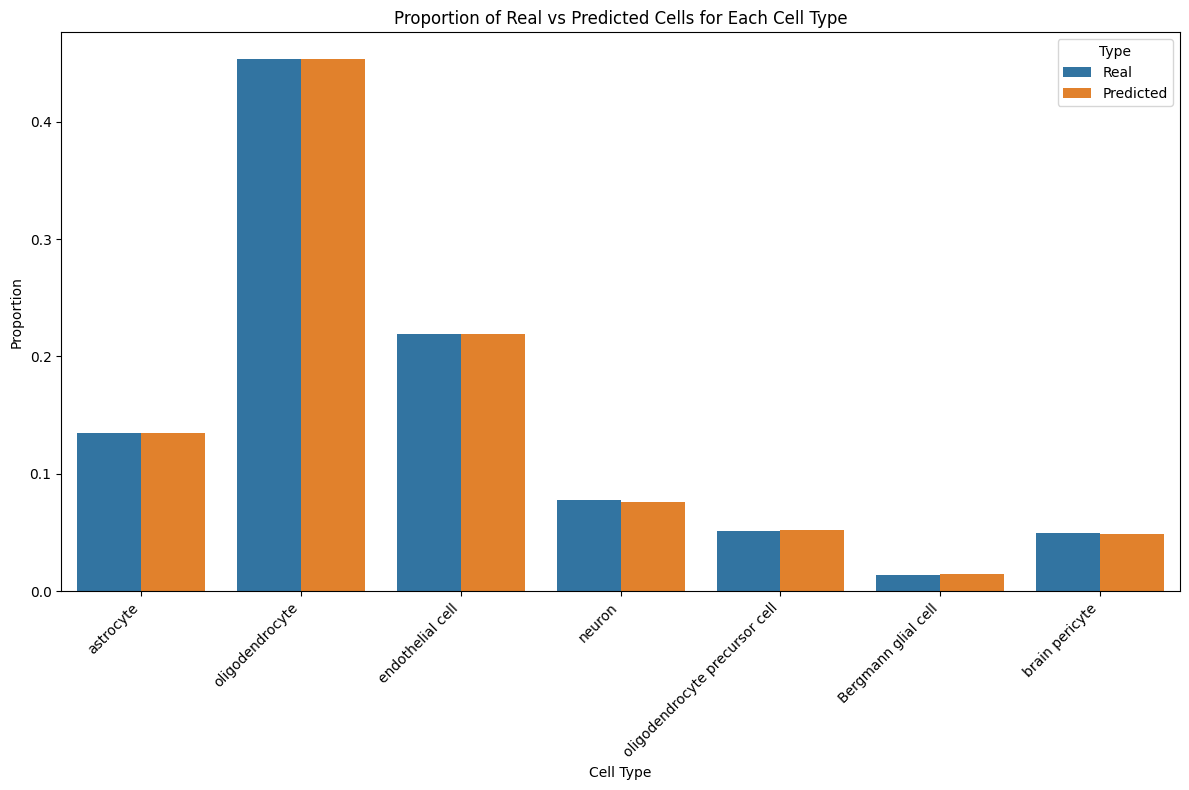

In [ ]:


results_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
true_counts = results_df['True'].value_counts().sort_index()
predicted_counts = results_df['Predicted'].value_counts().sort_index()
all_classes = sorted(set(true_counts.index).union(predicted_counts.index))
true_counts = true_counts.reindex(all_classes, fill_value=0)
predicted_counts = predicted_counts.reindex(all_classes, fill_value=0)

# df, for plotting
proportion_df = pd.DataFrame({
    'Cell Type': [label_mapping[i] for i in all_classes],
    'Real': true_counts / true_counts.sum(),  # Normalize to proportions
    'Predicted': predicted_counts / predicted_counts.sum()  # Normalize to proportions
}).melt(id_vars=['Cell Type'], var_name='Type', value_name='Proportion')
plt.figure(figsize=(12, 8))
sns.barplot(data=proportion_df, x='Cell Type', y='Proportion', hue='Type')
plt.xticks(rotation=45, ha='right')
plt.title("Proportion of Real vs Predicted Cells for Each Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("Proportion")
plt.legend(title="Type")
plt.tight_layout()
plt.show()
